#A. Summary

In the project, we used demand forecasting to meet customer needs based on historical sales data. We used two methods to forecast the demand of the material from the client on the given date. We forecasted the aggregate demand for a given material from all clients at a specified date in the future, and forecasted the aggregate demand for all materials from a given client at a specific date in the future, without providing the client and the material respectively.
There are four main parts in the report. Part 2 explores the data through visualization. Part 3 presents the two forecasting methods which are the moving average (MA) and the autoregressive integrated moving average (ARIMA). We first used the simple moving average method to make the forecasts. It first calculates the average of a set of selected time periods and then presents the overall trend of the data set. This technique is very useful for forecasting short-term trends. In addition, we used the autoregressive integrated moving average (ARIMA) method. The ARIMA model can expressed as ARIMA(p,d,q), where p is the order of the autoregressive model, d is the degree of difference, and q is the order of the moving average model. The ARIMA model predicts future values based on historical data. And we illustrate the main functions in order to make accurate forecasts. In the last part, we outline how to use the forecasting tool.

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 15.8 MB/s 
     |████████████████████████████████| 9.8 MB 22.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from numpy import log
import sys
from datetime import date
from datetime import timedelta  

df = pd.read_csv("Top 10 Companies Orders.csv")

#B. Explanation and Visualization of the data

The original dataset used for the project included a total of four columns, date, client, material, and order quantity. It records the sales from 2019 to 2020. The clients are represented by "c1" to "c10" and there are ten clients in total. The number of materials is 901 in total, and each material is represented by a 7-digit code separately. The column for the number of orders represents the number of a material that was purchased.

To get an overview of the data set and to determine if there are any trends, we plotted graphs for each client, each material, and each pair of clients and materials at different times.

In [ ]:
def sum_df(df):
  #sum up all demands of the same material, for the same client and on the same date
  clean_df = df.groupby(['Date', 'Client name', 'Material']).agg({'Order Quantity': ['sum']})
  clean_df.columns = ['Order Sum']
  clean_df = clean_df.reset_index()

  #sort data by dates
  clean_df['Date']=pd.to_datetime(clean_df['Date'])
  clean_df = clean_df.sort_values(by='Date')
  clean_df.reset_index(inplace=True)
  clean_df.drop(columns=['index'],inplace=True)
  return clean_df

In [ ]:
df1 = sum_df(df)

#find the number of materials and clients
df1['Client name'].unique()
# 'c9', 'c6', 'c1', 'c8', 'c5', 'c4', 'c7', 'c3', 'c10', 'c2'
print('Number of clients: 10')
a = df1['Material'].unique()
print('Number of materials:', len(a))

Number of clients: 10
Number of materials: 901


In [ ]:
#check null values
df1.isnull().sum()

Date           0
Client name    0
Material       0
Order Sum      0
dtype: int64

### Given each client find aggregated demand of material

First, we plotted the graphs of the aggregate demand of the materials for each client on a given date, showing the total number of materials ordered by each client on each specific date. The graph below shows the total material demand for each client over time. For example, clients c9, c6, c1, c8 are on an overall upward trend from 2019 to 2020, and then the ordering trend is stable during 2020.

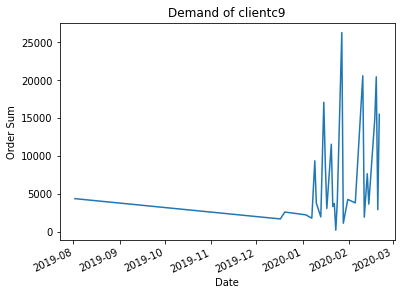

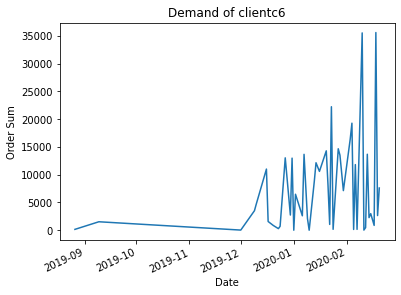

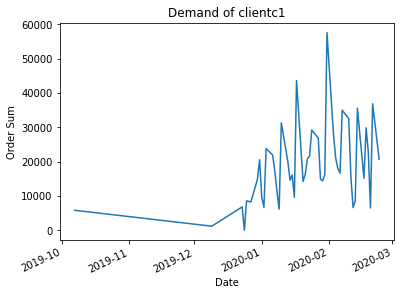

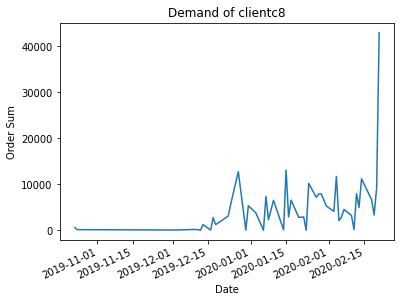

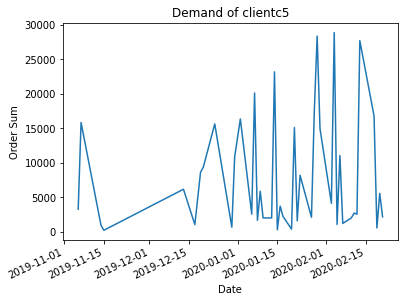

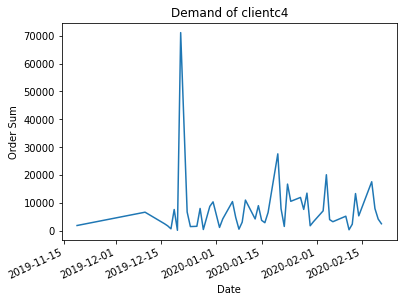

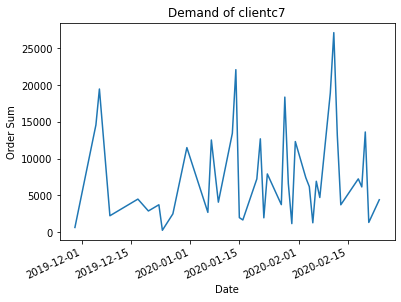

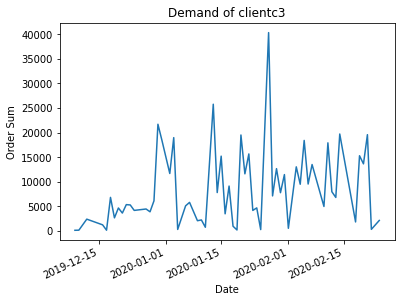

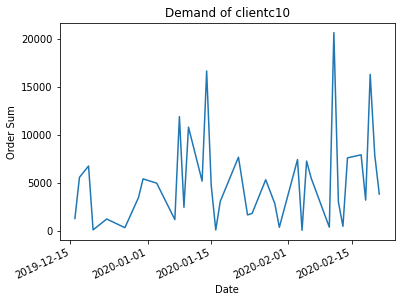

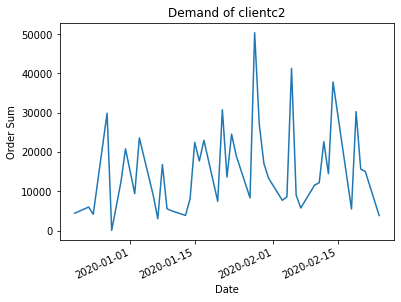

In [ ]:
df3 = df1.copy()
df2 = df1.copy()
c_list = df1['Client name'].unique()
for c_name in c_list:
  ct = df1.loc[df1['Client name']==c_name]
  
  ct = ct.groupby(['Date']).sum()
  ct.drop(columns=['Material'],inplace=True)
  ts = ct['Order Sum']

  sns.lineplot(data=ts)
  plt.title('Demand of client' + c_name)
  plt.xticks(rotation=25, horizontalalignment = 'right')
  plt.show()

### Given each material find aggregated demand of client (only focus on popular materials)

Next, since there are 901 materials, we selected the top 20 most popular materials to show the graphs of the aggregate demand of the clients who ordered these 20 materials on each specific date. The graph below shows the total clients demand for each material over time. For example, the number of orders for three materials 12311290, 12216834, and 12293783 have remained essentially relatively constant. Other materials fluctuate a bit from 2019 to 2020, such as material 12102902.

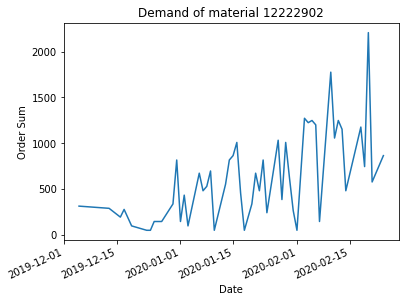

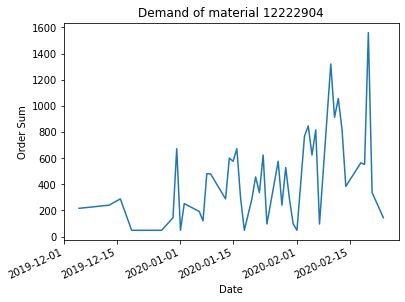

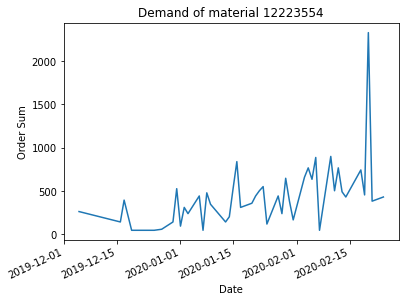

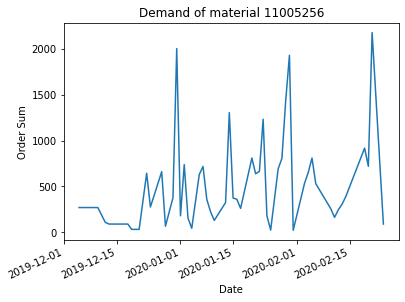

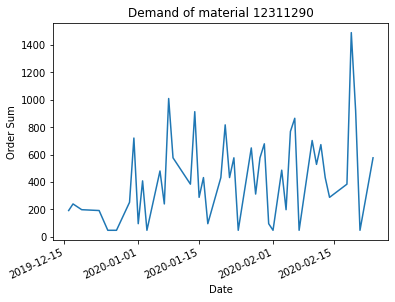

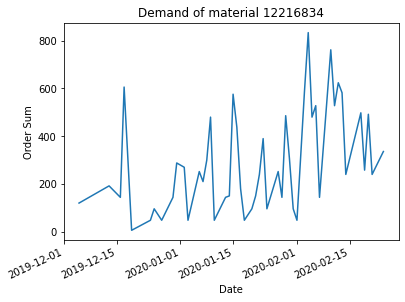

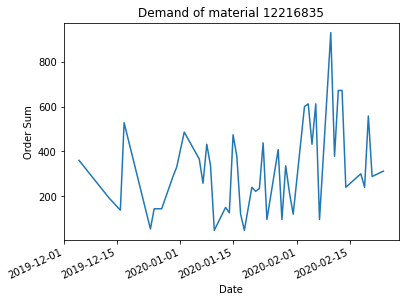

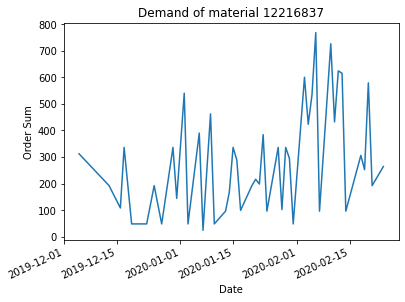

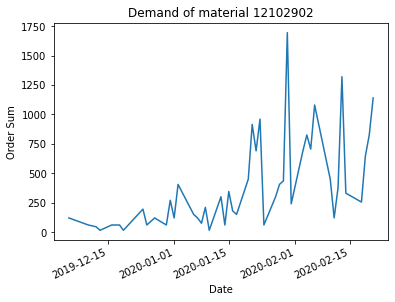

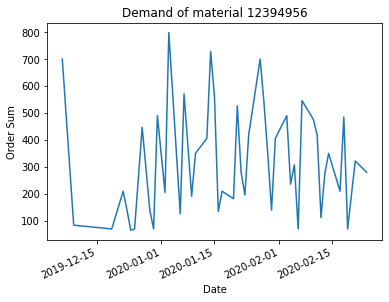

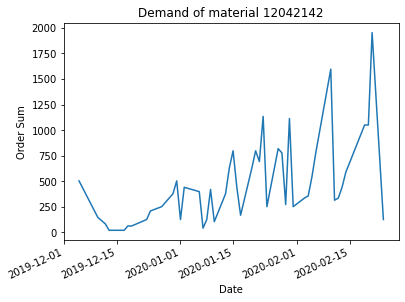

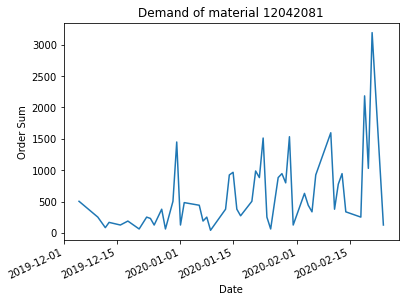

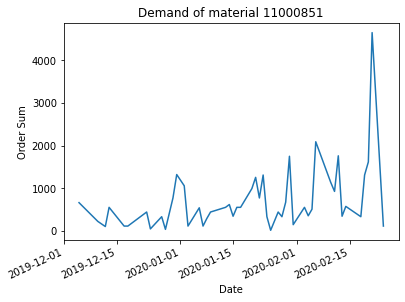

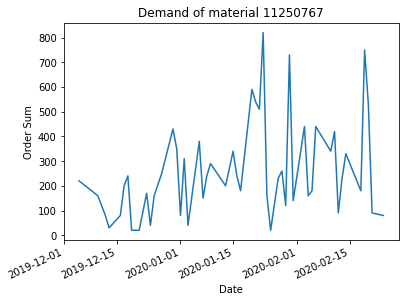

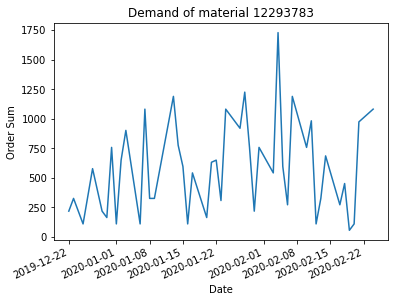

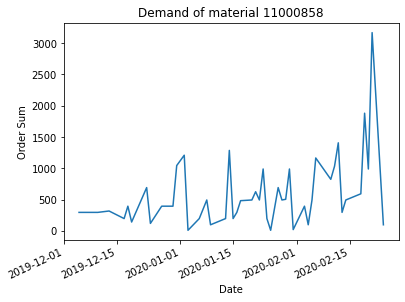

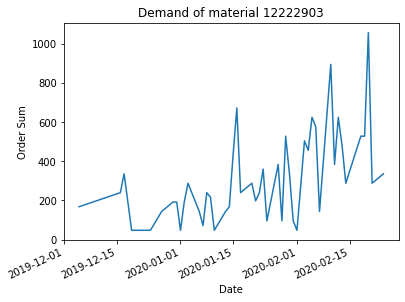

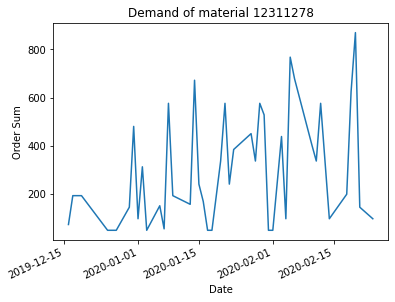

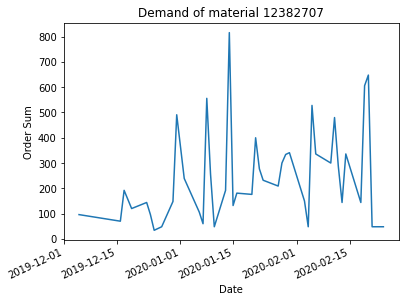

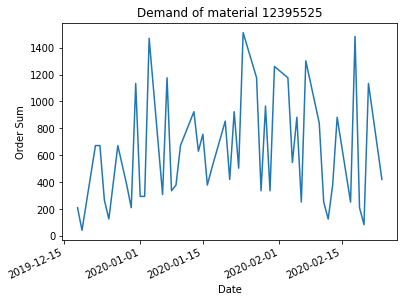

In [ ]:
m_num = df1['Material'].value_counts()
for i in range(20):
  m_ind = m_num.index
  m_name = m_ind[i]
  mt = df1.loc[df1['Material']==m_name]
  mt = mt.groupby(['Date']).sum()
  ts = mt['Order Sum']

  sns.lineplot(data=ts)
  plt.title('Demand of material '+ str(m_name))
  plt.xticks(rotation=25, horizontalalignment = 'right')
  plt.show()

### Given specific client and material

Then, the graphs below show the demand for each pair of clients and materials. From these graphs, we can see the demand of each client for the top 20 materials has changed over time.

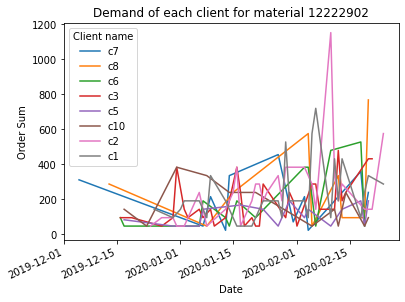

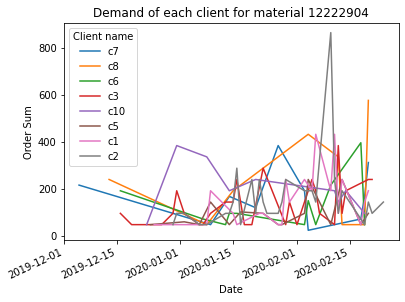

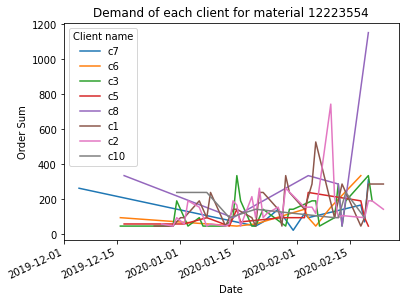

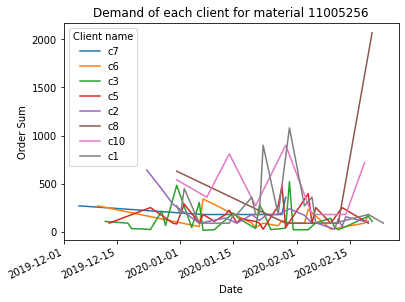

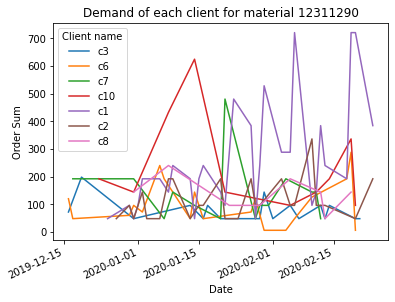

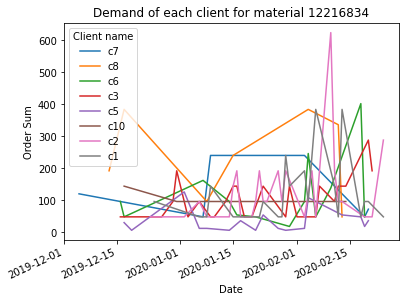

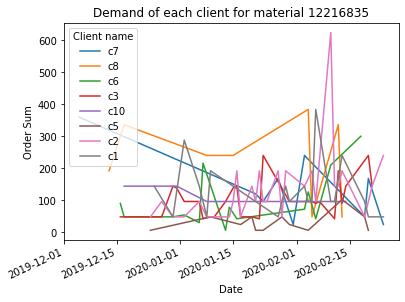

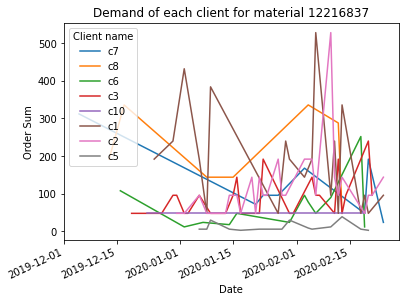

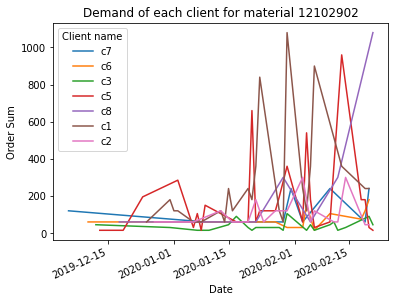

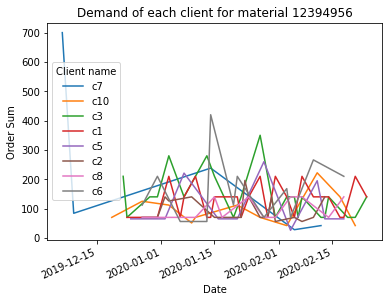

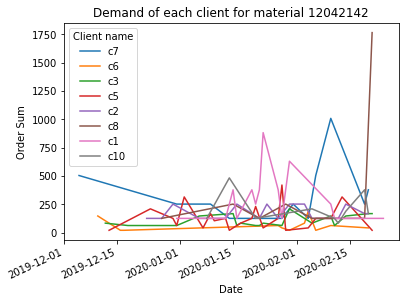

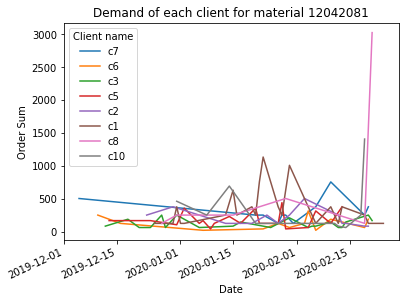

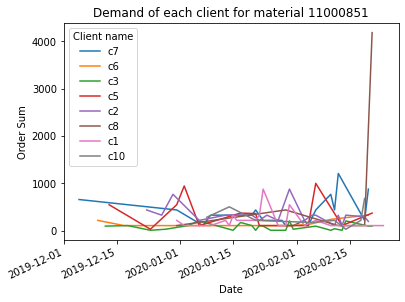

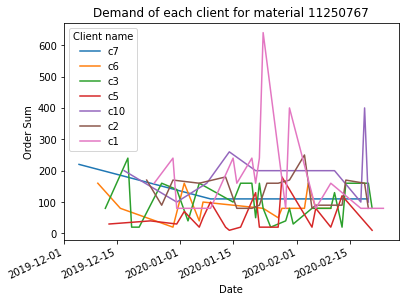

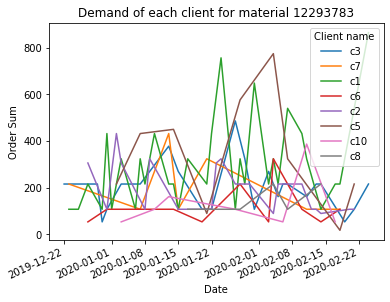

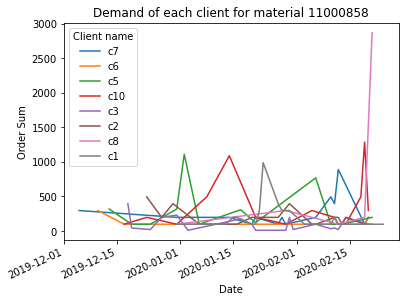

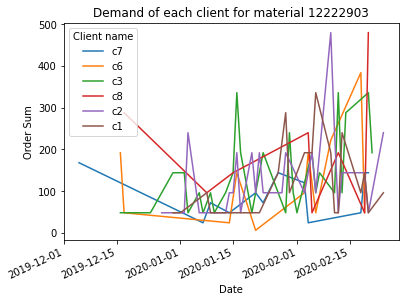

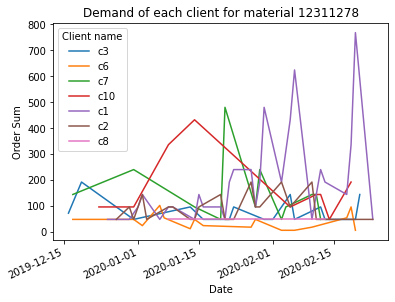

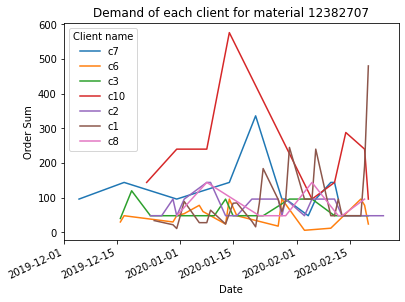

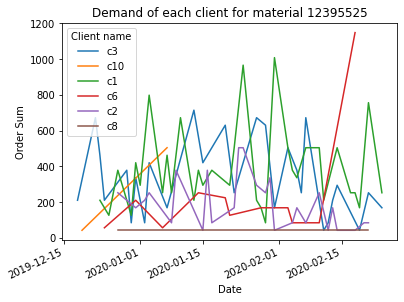

In [ ]:
for c in range(20):
  mind = m_num.index
  mc = mind[c]
  m11 = df1.loc[df1['Material']==mc]
  m11.drop(columns=['Material'], inplace = True)
  sns.lineplot(data=m11,x='Date', y='Order Sum', hue='Client name')
  plt.title('Demand of each client for material '+ str(mc))
  plt.xticks(rotation=25, horizontalalignment = 'right')
  plt.show()

# C. Method
Two forecasting methods have been included in this project. The first method is the Simple Moving Average, which was taught in the first week of the APS 1017 course. And the second method is a method that the group has researched and studied by themselves, which is the Autoregressive Integrated Moving Average (ARIMA).  

## Method 1 - Moving Average (Simple Moving Average)

The Moving Average technique, also known as Rolling Average, is widely used in many different fields such as operation management and finance, it is a simple but popular forecasting technique for stationary time series. This technique calculates the overall trend in a data set and it is known to be very useful for forecasting short-term trends. There are also several types of moving average methods such as simple moving average, exponential moving average, weighted moving average, etc. The first chosen method in this project is one of the forecasting techniques that has been discussed and taught in the course for forecasting stationary time series, Simple Moving Average.

The Simple Moving Average is an unweighted moving average, in other words, all the weight factors are equal to 1 in the Simple Moving Average. A moving average of order N is simply the arithmetic average of the most recent N observations, where the N represents the number of periods. Thus, the formula can be expressed as follow:

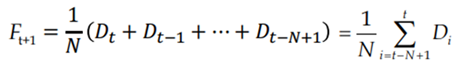

As explained above, the forecast of the next period F(t+1) is calculated as the mean of the N most recent observations with the Moving Average method. And this method can be denoted as MA(N) for N-period moving averages. According to the assumption of this method, the demand series is stationary, the forecasting for the multiple-step-ahead will be identical to one-step-ahead, and that is F(t) = F(t+1) = F(t+2)…. However, with the Moving Average forecasting method, one must recompute the average of the last N observations each time a new demand observation becomes available, and when N is large, the process can be lengthy and tedious.

In the following section, a model that includes multiple functions will be established based on the concept of the Simple Moving Average technique to forecast demands in Python. The goal of this model is to take the inputs from the user and perform demand forecasting based on the given dataset. To better meet the goal, demand forecasting can be discussed and performed in three scenarios based on the input values: when the client is not given (client = None), when the material is not given (Material = None), and when both are given. When the client is not given, the model will forecast aggregate demand for the given material from all clients, and when the material is not given, the model will forecast aggregate demand for all the materials from the given clients. In the first two scenarios, the calculation of the forecast will be based on the previous seven observations. However, the client and material are paired up in the last scenario, and the window(N) will be adjusted accordingly based on the number of the order recorded in the given datasets.  Please also note that since the multiple-step-ahead forecasting is the same as one-step-ahead forecasting in Moving Average, the date will not be used as a parameter. In addition, when the given client or material does not exist in the original dataset, the model will not recognize the input or perform the demand forecasting and an error message will be displayed. More detailed model and function explanations can be found in the next section.


##Method 2 - ARIMA

The second forecasting method that the team uses is ARIMA, which stands for the autoregressive integrated moving average. ARIMA models provide another approach to time series forecasting. It is one of th most  widely used approaches to time series forecasting, and it provides complementary approaches to the problem. While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data.

The ARIMA model can be obtained by combing the autoregression model, with moveing average (MA) model. The autoregression model forecasts the variable using a linear combination of the past values of the variable, and the MA model is the one we used in method 1. The mathmatical formula of the full ARIMA model is as follows:

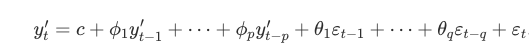

The yt′ on the lefthand side the formula refers to the differenced series (it may have been differenced more than once). The “predictors” on the right hand side in the formula include both lagged values of yt and lagged errors. This is a general formula for an ARIMA(p,d,q) model, where
p = the number of lag observation from the autoregressive terms;
d = degree of first differencing involved;
q = order of the moving average part.

The same stationarity and invertibility conditions that are used for autoregressive and moving average models also apply to an ARIMA model.
While p and q stand for the order of AR terms and MA terms, the d value, which is the degrees of difference, is also critical. This is because using stationary data such that the mean and variance are roughly consistent over the time horizon is very important for time-series forecasting. The procedure of differencing the data can effectively smooth out the seasonality and trends which is common in the sales dataset as business activities tend to grow over the years.
Once the model order has been identified (i.e., the values of p, d and q), we then need to estimate the parameters c, phi and theta parameters as stated in the ARIMA formula. The maximum likelihood estimation (MLE) technique will find the values of the parameters which maximise the probability of obtaining the data that we have observed. For ARIMA models, MLE is similar to the least squares estimates that would be obtained by minimising all the errors terms. 
In practice, the ARIMA function will report the value of the log likelihood of the data, which is the logarithm of the probability of the observed data coming from the estimated model. For given values of p, d and r, the ARIMA function will try to maximise the log likelihood when finding parameter estimates.

Akaike’s Information Criterion (AIC), and  Bayesian Information Criterion (BIC) are both useful in selecting predictors for regression and determining the order of an ARIMA model. Good models are obtained by minimising the AIC, AICc or BIC. 

For ARIMA models, the corrected AIC can be written as:

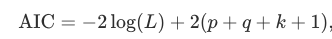

and the BIC can be written as:

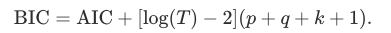


The team has assumed that the time-series data for each pair of client and material is stationary based on data exploration and visualization. Therefore, the group adopted an automated stepwise search method to determine the best ARIMA model with a suite of parameters. With a grid of p, d, and q values, the procedure iterated through each combination of parameters and keep track of the configuration with the reported statistics. The model optimization step generates a list of candidate ARIMA models along with the fitting statistics of each model and chooses the best model to proceed, and the model with the lowest AIC and BIC shows the best performance.



> References [1] https://otexts.com/fpp2/arima-estimation.html

> References [2] https://towardsdatascience.com/understanding-arima-time-series-modeling-d99cd11be3f8 




# D. Explanation of Major Function in the Code

## Major function - SMA

The forecast function for simple moving average we defined has named as ‘sma’. From historical demand dataset, we have total 10 client names from ’c1’ to ‘c10’, and 901 kinds of different materials named in eight digits number.

For data cleaning, we continue to use previous data in visualization, which had already summed up all demand for same client of same material in the same day.

First, we check if  input variables are in the given dataset, as we need historical data to forecast future demand. If input client name or material are out of range, the function will print out corresponding warning message to inform users change variable.

Then for the scenario of not given material, the function ‘groupby’ all data for given client and use rolling window of 7 as a week to forecast future demand, which is similar to the scenario of not given client.

The final case is happened when both client and material are given. The function filtered data under given two variables and saved in a list named ‘ts’. In this case, due to the probably nonsufficient historical data, the function flexibly adjusts the rolling window according to the length of given list ‘ts’. Then we are able to do the forecast even though historical data is not enough for a week.

For each case, we presented a sample of function forecast output below for reference.


In [ ]:
def sma(cname, m_ind, df1=df3):
  #1. When given client or material not in range:
  material_list = df1['Material'].unique()
  client_list = df1['Client name'].unique()
  if cname not in client_list and cname != None:
    print('Forecast is not achievable as the given client is out of range')
  elif m_ind not in material_list and m_ind != None:
    print('Forecast is not achievable as the given material is out of range')

  #2. When given material or client in range:
  #2.1When client is not given:
  elif cname == None:
    m1 = df1.loc[df1['Material']==m_ind]
    m1 = m1.groupby(['Date']).sum()
    m1.drop(columns=['Material'],inplace=True)
    ts = m1['Order Sum']
    fore = ts.rolling(window=7).mean()
    final = fore[-1]
    print('Given no clients, forecast demand for material %s: %.1f' % (m_ind, int(final)))

  #2.2When material is not given:
  elif m_ind == None:
    c1 = df1.loc[df1['Client name']==cname]
    c1 = c1.groupby(['Date']).sum()
    c1.drop(columns=['Material'],inplace=True)
    ts = c1['Order Sum']
    fore = ts.rolling(window=7).mean()
    final = fore[-1]
    print('Given no material, forecast demand for client %s: %.1f' % (cname, int(final)))

  #2.3When both material and client are given:
  else:
    c1 = df1.loc[df1['Client name']==cname]
    m1 = c1.loc[c1['Material']==m_ind]
    m1 = m1.groupby(['Date']).sum()
    m1.drop(columns=['Material'],inplace=True)
    ts = m1['Order Sum']
    if len(ts) == 0:
      print('No historical data for given client and material')
    elif len(ts)<7:
      n = len(ts)
      fore = ts.rolling(window=n).mean()
      final = fore[-1]
      print('Given material %s and client %s, forecast demand: %.1f' % (m_ind, cname, int(final)))
    else:
      fore = ts.rolling(window=7).mean()
      final = fore[-1]
      print('Given material %s and client %s, forecast demand: %.1f' % (m_ind, cname, int(final)))
  return  

Below there is a simple example to see how 'sma' forecast function perform.

In [ ]:
sma('c8', 12412276) #Given both client and material

Given material 12412276 and client c8, forecast demand: 23.0


##Major function - ARIMA

**1. Initial library import:**

> We import the initial panda, numpy and ARIMA stats models that will be used to clean and forcast our data in the later stages. For ARIMA package, we used pmdarima which is a statistical library designed to fill the void in Python's time series analysis capabilities. Some of its key functionalities includes obtaining the best ARIMA function with auto.arima, performing statistical tests of stationarity and seasonality, as welll as time series utilities, such as differencing and inverse differencing. It also supports seasonal time series decompositions if a seasonal compomenet is needed for the model.  

> Reference: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html







**2. Data Pre-processing:**



> Similar to the data processing steps in MA, the first step of the data preparation is to groupby the data by Date, Client, and Material to find the order sum, which will be the variable that we are forcasting. We also check for null data and value count in the dataset to make sure there are not n/a and empty cells.



In [ ]:
df2

,Date,Client name,Material,Order Sum
0,2019-08-02,c9,11332492,1500
1,2019-08-02,c9,12420232,2844
2,2019-08-26,c6,12412276,91
3,2019-08-26,c6,12412248,17
4,2019-08-26,c6,12412275,45
...,...,...,...,...
28725,2020-02-24,c1,12404650,19
28726,2020-02-24,c1,12404647,28
28727,2020-02-24,c1,12404646,66
28728,2020-02-24,c1,12407750,60


In [ ]:
df2['Material'].value_counts()

12222902    157
12222904    134
12223554    131
11005256    129
12311290    129
           ... 
12303984      1
12412280      1
12324351      1
12321917      1
12427543      1
Name: Material, Length: 901, dtype: int64

In [ ]:
df2['Client name'].value_counts()

c1     6909
c3     5561
c2     5409
c6     2879
c7     2332
c5     2140
c10    1529
c8     1528
c4      370
c9       73
Name: Client name, dtype: int64

**3. ARIMA Input data preparation:**


> We also further define the input format to handle missing parameters when calling the forcasting function:

*   if we do not want to provide client or material name, then define client=None or material=None;
*   if client name is defined e.g. client="c1", then client name is a string；
*   if material name is defined e.g. material=12240834, then material name is a number;
*   if we define a future date, then we will be using format like this: "month/day/year", which is a string.


> Next, we define a function called data_prep to extract the historical data based on the inputs. The rules are:

*   if client is not given, but material name is given, then we aggregate demand for the given material from all clients;
*   if client name is given but material name is not given, then we aggregate demand for all the materials from the given client；
*   if material and client name both are given, then we select corresponding demand for forecasting;
*   otherwise, we print out a warning message to let the user check their inputs and try again.


In [ ]:
# preparing the data based on inputs
def data_prep(client, material, df1):
  if (client is None) and (material is not None) : #If client is not given
  # aggregate demand for the given material from all clients
    df=df1.loc[(df1['Material'] == material)]
    df_agg=df.groupby(['Date']).agg({'Order Sum': ['sum']})
    df_agg.columns = df_agg.columns.droplevel(level=1)
  elif (client is not None) and (material is None): #If material is not given
  # aggregate demand for all the materials from the given client
    df=df1.loc[(df1['Client name'] == client)]
    df_agg=df.groupby(['Date']).agg({'Order Sum': ['sum']})
    df_agg.columns = df_agg.columns.droplevel(level=1)
  elif (client is not None) and (material is not None):
    df=df1.loc[(df1['Client name'] == client) & (df1['Material'] == material)].set_index('Date')
    df_agg=df.drop(['Client name','Material'],axis=1)
  else:
    return print("Wrong Information! Please check your input.")
    
  return df_agg
 

**4. ARIMA forcasting function:**

We use auto.arima from the pmdarima library to find the optimal ARIMA model for prediction. The auto.arima() function uses a variation of the Hyndman-Khandakar algorithm (Hyndman & Khandakar, 2008), which combines unit root tests, minimizing BICs to obtain an ARIMA model. 

Note: BIC is appropriate for models fit under the maximum likelihood estimation framework. The BIC statistic is calculated for logistic regression as follows:

BIC = -2 * LL + log(N) * k

Where log() has the base-e called the natural logarithm, LL is the log-likelihood of the model, N is the number of examples in the training dataset, and k is the number of parameters in the model.

The score as defined above is minimized, e.g. the model with the lowest BIC is selected. Unlike the AIC, the BIC penalizes the model more for its complexity, meaning that more complex models will have a worse (larger) score and will, in turn, be less likely to be selected.

The number of differences d is determined using repeated KPSS tests, and the data will become stationary after diferencing d times.
The values of p and q are then chosen by minimizing the BIC after differencing the data d times. Rather than considering every possible combination of p and q, the algorithm uses a stepwise search to traverse the model space.

Reference: 
* https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

* https://machinelearningmastery.com/probabilistic-model-selection-measures/

In [ ]:
# Forecasting using ARIMA model
def forecast_ARIMA(client, material, futureDate, df1):
  f_date = pd.to_datetime(futureDate) #convert input date to datetime format
  df_ts= data_prep(client, material, df1)
  if df_ts.empty==True:
    print("Inputs does not have corresponding historical data, therefore couldn't make forecasting. Please try giving either client or material input, do not provide both.")
    return None
  else:
    print("The historical data given inputs is:\n", df_ts)
    model = pm.auto_arima(df_ts, start_p=1, start_q=1,
                          test='kpss',       # use kpss test to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # Assume no Seasonality
                          D=None, 
                          trace=True,
                          max_d=3,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True,
                          information_criterion="bic")
    print(model.summary())
    d0= df_ts.index[len(df_ts.index)-1].to_pydatetime().date() #find the latest date of data
    d1= f_date.to_pydatetime().date() 
    delta= d1 - d0
    n_periods = delta.days #calculate how many days to forecast given the input of future date
    #print("Number of days from the latest date is", n_periods)
    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    fc_index= pd.date_range(pd.to_datetime(d0)+timedelta(days=1),pd.to_datetime(d1)) #find the time index of forecast series
    fc_series = pd.Series(fc,index=fc_index)
    print("****** ****** ****** ****** ****** ****** ****** ****** ****** ****** ****** ****** ****** ****** ****** ****** ****** ")
    print("The forecasts are:\n", fc_series)
    print('Given material %s and client %s, forecast demand on the given future date %s is: %.1f' % (material, client, d1, int(fc_series[-1])))

  return client, material, d1, int(fc_series[-1])

# E. How to Use
In this section, a comprehensive guide on how to use the models built in the previous section to perform demand forecasting will be provided.

Format and rules when entering inputs:

•	Enter client as a string, for example, “c1”

•	Enter material as an integer, for example, 12311292

•	Enter future data in format "MM/DD/YYYY", for example, "2/28/2020"

•	If the user wishes not to include client or material, enter None

•	Either client or material can be None, but not both at the same time




## SMA
To perform Demand Forecasting with MA/SMA, users can use the function **sma** and enter the desired client and material ID in the function. Users do not need to enter a date as the result will not be different when a different date is entered.

For example: 

•	Enter sma('c8', 12412276) to see the demand forecast of client “c8” with material 12412276

•	Enter sma('c6', None) if wish to see the demand forecast of client “c6”

•	Enter sma(None, 11250174) if wish to see the demand forecast of material 11250174

•	If entered client or material is out of range, the user will see a message “Forecast is not achievable as the given client is out of range” OR “Forecast is not achievable as the given material is out of range”

**Example**

In [ ]:
sma('c1', 12311292) #Given both client and material
sma('c6', None) #Given only client 'c6'
sma(None, 11250174) #Given only material '11250174'
sma('c100', 11250174) #Given client out of range
sma('c6', 100) #Given material out of range

Given material 12311292 and client c1, forecast demand: 7.0
Given no material, forecast demand for client c6: 9369.0
Given no clients, forecast demand for material 11250174: 421.0
Forecast is not achievable as the given client is out of range
Forecast is not achievable as the given material is out of range


## ARIMA

To perform the demand forcasting using ARIMA, user would call the forcast_ARIMA function and pass in the client ID, material number, and forcast date as parameters. It's also possible to predict with only particial information, as illustrated in the below three examples.

**Example 1: When three inputs (client, material, date) are all provided**

In [ ]:
# an example on how to using the forecast function
c1, m1, d1, fc1 = forecast_ARIMA("c6", 12412276, "2/28/2020", df2)

The historical data given inputs is:
             Order Sum
Date                 
2019-08-26         91
2019-09-09          3
2020-02-04        150
Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=37.321, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=38.415, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=38.418, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=35.317, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=33.587, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.464 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    3
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 

In [ ]:
#print out the forecasts
print('Given material %s and client %s, forecast demand on the given future date %s is: %.1f' % (m1, c1, d1, fc1))

Given material 12412276 and client c6, forecast demand on the given future date 2020-02-28 is: 67.0


In this example 1, with the prepare data for client “c6” and material 12412276,and a future date of 2/28/2020, a list with 8 valid models and their AIC and BIC scores are provided in the output. The model ARIMA(1,0,0) with intercept has the lowest AIC and BIC of 36.291 and 33.587. Hence it will be selected as the most suitable model for the forecasting stage, and the forcasted demand for given future date is 67.

**Example 2: When client name is not provided**

In [ ]:
c2, m2, d2, fc2=forecast_ARIMA(None, 12222902, "2/28/2020", df2)

The historical data given inputs is:
             Order Sum
Date                 
2019-12-05        312
2019-12-13        288
2019-12-16        192
2019-12-17        276
2019-12-19         96
2019-12-23         48
2019-12-24         48
2019-12-25        144
2019-12-27        144
2019-12-30        336
2019-12-31        816
2020-01-01        144
2020-01-02        432
2020-01-03         96
2020-01-06        672
2020-01-07        480
2020-01-08        528
2020-01-09        696
2020-01-10         48
2020-01-13        552
2020-01-14        816
2020-01-15        864
2020-01-16       1008
2020-01-17        456
2020-01-18         48
2020-01-20        336
2020-01-21        672
2020-01-22        480
2020-01-23        816
2020-01-24        240
2020-01-27       1032
2020-01-28        384
2020-01-29       1008
2020-01-30        624
2020-01-31        264
2020-02-01         48
2020-02-03       1272
2020-02-04       1224
2020-02-05       1248
2020-02-06       1200
2020-02-07        144
2020-02-10      

In [ ]:
#print out the forecasts
print('Given material %s and client %s, forecast demand on the given future date %s is: %.1f' % (m2, c2, d2, fc2))

Given material 12222902 and client None, forecast demand on the given future date 2020-02-28 is: 1022.0


In example 2, with the prepare data for material 12222902,and a future date of 2/28/2020, a list with 13 valid models and their AIC and BIC scores are provided in the output. The model ARIMA(0,0,1) without intercept has the lowest AIC and BIC of 750.320 and 754.144. Hence it will be selected as the most suitable model for the forecasting stage, and the forecasted demand on the given future date is 1022.

**Example 3: When material name is not provided**

In [ ]:
c3, m3, d3, fc3=forecast_ARIMA("c6", None, "2/28/2020", df2)

The historical data given inputs is:
             Order Sum
Date                 
2019-08-26        153
2019-09-09       1521
2019-12-01         23
2019-12-09       3511
2019-12-10       4639
2019-12-16      11001
2019-12-17       1568
2019-12-20        858
2019-12-23        284
2019-12-24        709
2019-12-27      13022
2019-12-30       2732
2019-12-31      12971
2020-01-01          2
2020-01-02       6472
2020-01-06       2596
2020-01-07      13656
2020-01-09       2108
2020-01-10          1
2020-01-13       8800
2020-01-14      12140
2020-01-16      10586
2020-01-20      14283
2020-01-21       8209
2020-01-22       1041
2020-01-23      22220
2020-01-24        160
2020-01-27      14657
2020-01-28      13492
2020-01-30       7125
2020-02-03      16387
2020-02-04      19261
2020-02-05        137
2020-02-06      11808
2020-02-07        153
2020-02-10      35505
2020-02-11         24
2020-02-12        473
2020-02-13      13671
2020-02-14       2263
2020-02-15       2980
2020-02-17      

In [ ]:
#print out the forecasts
print('Given material %s and client %s, forecast demand on the given future date %s is: %.1f' % (m3, c3, d3, fc3))

Given material None and client c6, forecast demand on the given future date 2020-02-28 is: 11682.0


In example 3, with the prepare data for client 'c6' and a future date of 2/28/2020, a list with 11 valid models and their AIC and BIC scores are provided in the output. The model ARIMA(0,1,2) with intercept has the lowest AIC and BIC of 922.996 and 930.132. Hence it will be selected as the most suitable model for the forecasting stage, and the forecasted demand on the given future date is 11682.